## Goal: how does gene length affect # and type of transcript detection?

Maybe I need to also split by whether the transcript was a promoted ISM

Also probably split out by annotated and non-annotated genes

Also by biotypes

In [85]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [86]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [87]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [88]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [89]:
# get gene lengths from the gtf
f = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(f)
gtf_df = gtf_df.df

# just genes
gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
gtf_df['gene_len'] = gtf_df['End']-gtf_df['Start']


# merge gene len into mt
gtf_df['geneid.v'] = gtf_df['gene_id']
mt_df = mt_df.merge(gtf_df[['geneid.v', 'gene_len']], 
                    how='left',
                    on='geneid.v')

# make sure all nulls are from novel genic things
assert len(set(mt_df['geneid.v'].tolist())-set(gtf_df['gene_id'].tolist())) == len(mt_df.loc[mt_df['geneid.v'].str.contains('novelGenic')][['geneid.v']].drop_duplicates())

# remove novel genic things
mt_df = mt_df.loc[mt_df.gene_len.notnull()]

## First, general distributions

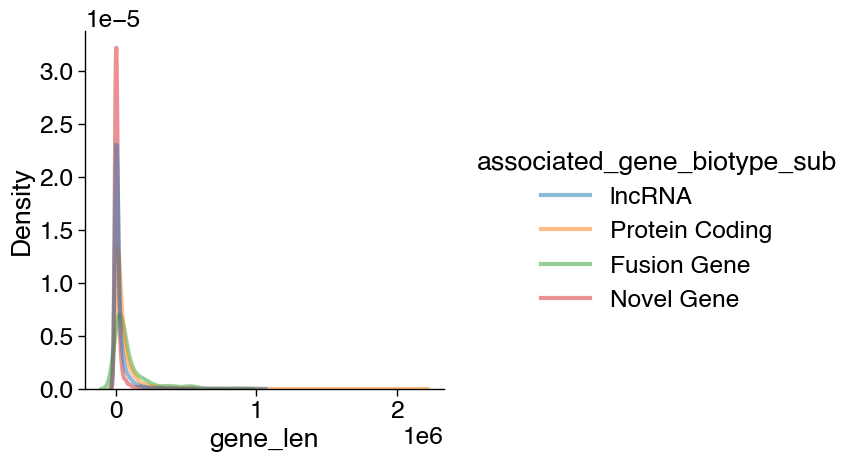

In [90]:
# biotype
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
init_plot_settings()
ax = sns.displot(temp,
                 x='gene_len', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)

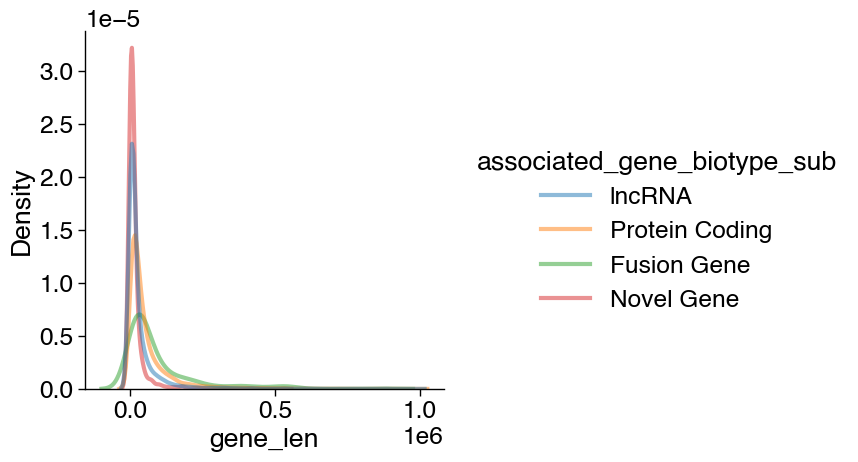

In [91]:
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.gene_len<1e6]
init_plot_settings()
ax = sns.displot(temp,
                 x='gene_len', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)

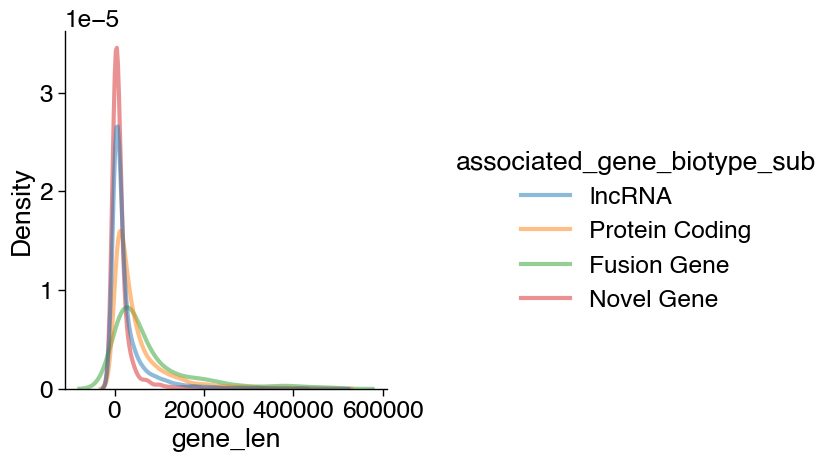

In [92]:
# biotype
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.gene_len<500000]
init_plot_settings()
ax = sns.displot(temp,
                 x='gene_len', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)

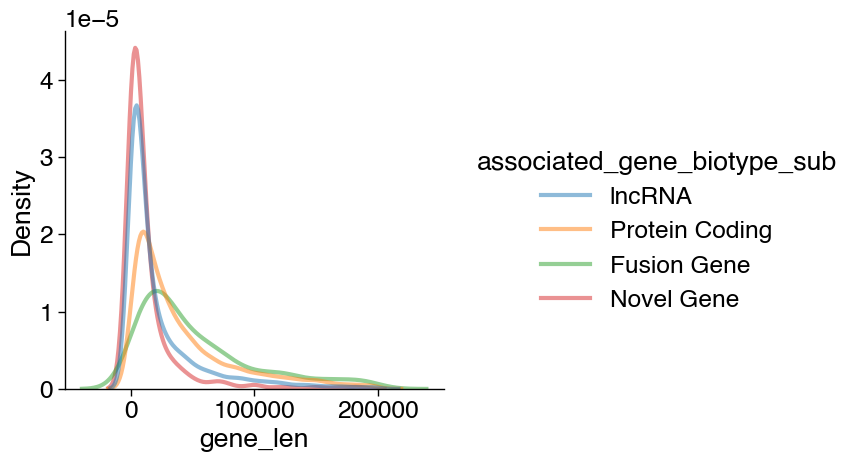

In [93]:
# biotype
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.gene_len<200000]
init_plot_settings()
ax = sns.displot(temp,
                 x='gene_len', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)

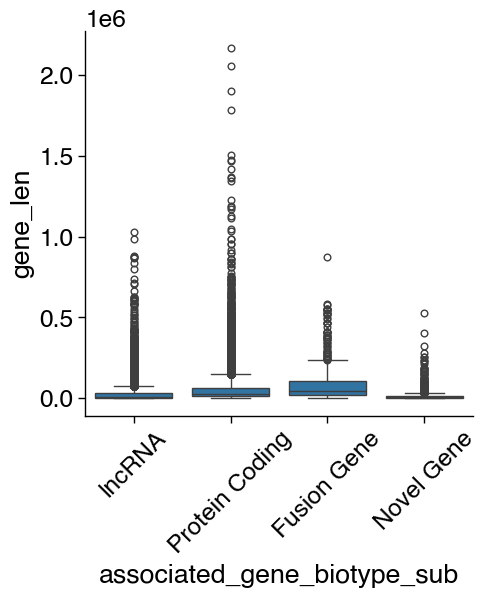

In [94]:
# biotype
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
init_plot_settings(aspect='square')
ax = sns.boxplot(temp,
                 y='gene_len',
                 x='associated_gene_biotype_sub')
clean_figure(ax)

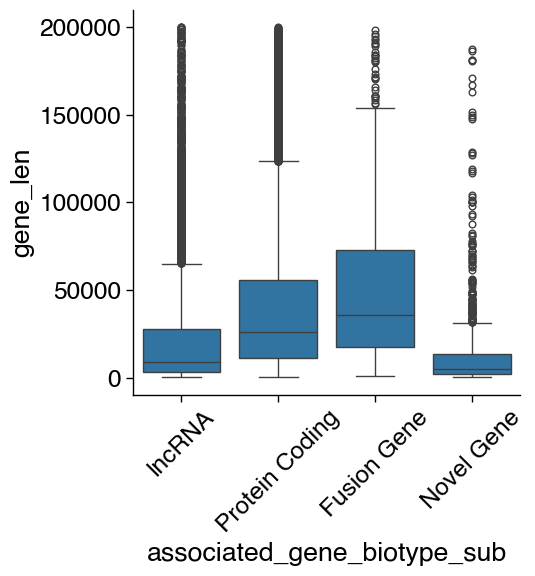

In [95]:
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.gene_len<200000]
init_plot_settings(aspect='square')
ax = sns.boxplot(temp,
                 y='gene_len',
                 x='associated_gene_biotype_sub')
clean_figure(ax)

In [96]:
## let's decile rank the data and look at bin ranges
temp = mt_df[['gene_len', 'geneid.v', 'associated_gene_biotype_sub']].drop_duplicates()
decile_rank, bin_edges = pd.qcut(temp['gene_len'], 10, labels=False, retbins=True)
temp['decile_rank'] = decile_rank
temp['decile_range'] = pd.qcut(temp['gene_len'], 10)
temp[['decile_rank', 'decile_range']].drop_duplicates()
# temp.loc[temp.decile_rank.isnull()]
# temp.loc[temp.decile_rank.isnull()][['associated_gene_biotype_sub', 'geneid.v']].groupby('associated_gene_biotype_sub').nunique()
temp['decile_range_width'] = temp['decile_range'].astype(str).str.split(',', expand=True)[1].str.slice(1,-1).astype(float) - \
                             temp['decile_range'].astype(str).str.split(',', expand=True)[0].str.slice(1).astype(float)


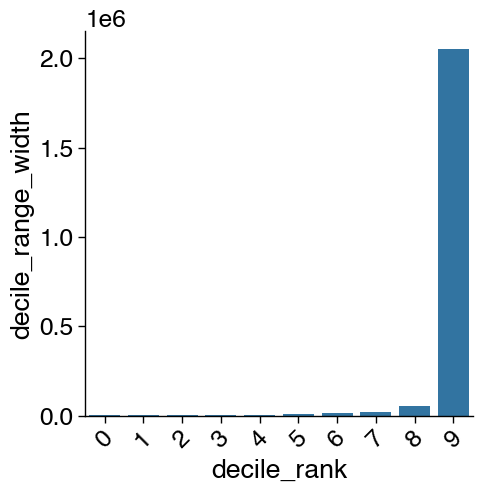

In [97]:
# visualize widths
init_plot_settings()
ax = sns.barplot(temp, x='decile_rank', y='decile_range_width')
clean_figure(ax)

In [98]:
# visualize the widths 2 electric boogaloo
temp2 = temp[['decile_rank','decile_range','decile_range_width']].drop_duplicates().sort_values(by='decile_rank', ascending=True)
temp2['decile_upper'] = temp2['decile_range'].apply(lambda x: x.right)
temp2.decile_upper = temp2.decile_upper.astype(float)
temp2['decile_upper_mb'] = temp2.decile_upper / 1e6
temp2['decile_upper_kb'] = temp2.decile_upper / 1e3


In [99]:
temp2.decile_upper_mb.unique()

array([0.0023454, 0.00482  , 0.0082646, 0.0129126, 0.019172 , 0.0284518,
       0.0421286, 0.0652474, 0.1170458, 2.168415 ])

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


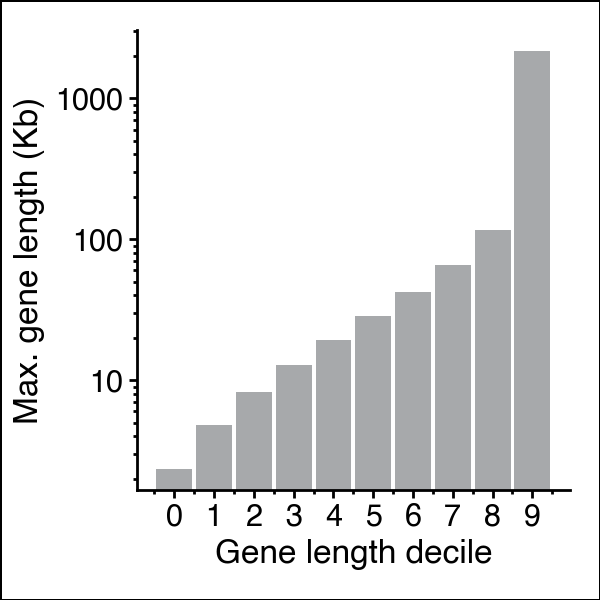

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 3 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: bar_gene_length_decile_definitions.pdf
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [100]:
p = (ggplot(temp2, aes(x='decile_rank', y='decile_upper_kb'))
    + geom_bar(stat='identity', fill='#a7a9ab')
    + my_theme(w=3, h=3)
    + labs(y='Max. gene length (Kb)',
          x='Gene length decile')
    + theme(legend_position='none')
    + scale_y_log10()
    + scale_x_continuous(breaks=range(0, 11))  # show all ticks 1–10

 
)
p.show()
p.save('bar_gene_length_decile_definitions.pdf', width=3, height=3, dpi=500)


In [101]:
temp['decile_range'].cat.ordered


True

In [102]:
# manually check the ranges
temp[['decile_rank','decile_range','decile_range_width']].drop_duplicates().sort_values(by='decile_rank', ascending=True)

,decile_rank,decile_range,decile_range_width
203,0,"(324.999, 2345.4]",2020.401
466,1,"(2345.4, 4820.0]",2474.600
564,2,"(4820.0, 8264.6]",3444.600
929,3,"(8264.6, 12912.6]",4648.000
12,4,"(12912.6, 19172.0]",6259.400
353,5,"(19172.0, 28451.8]",9279.800
48,6,"(28451.8, 42128.6]",13676.800
36,7,"(42128.6, 65247.4]",23118.800
0,8,"(65247.4, 117045.8]",51798.400
202,9,"(117045.8, 2168415.0]",2051369.200


In [103]:
temp.head()

,gene_len,geneid.v,associated_gene_biotype_sub,decile_rank,decile_range,decile_range_width
0,116763.0,ENSG00000296732.1,lncRNA,8,"(65247.4, 117045.8]",51798.4
12,13588.0,ENSG00000296775.1,lncRNA,4,"(12912.6, 19172.0]",6259.4
29,68983.0,ENSG00000306721.1,lncRNA,8,"(65247.4, 117045.8]",51798.4
35,12919.0,ENSG00000306767.1,lncRNA,4,"(12912.6, 19172.0]",6259.4
36,61518.0,ENSG00000274847.1,Protein Coding,7,"(42128.6, 65247.4]",23118.8


In [104]:
# merge in decile ranks w/ mt_df
mt_df = mt_df.merge(temp, 
                    how='left',
                    on=['geneid.v', 'gene_len', 'associated_gene_biotype_sub'])


## split by known / novel / promoted ISM

In [105]:
mt_df.structural_category.unique()

array(['FSM', 'NNC', 'Fusion', 'NIC', 'Antisense', 'Intergenic'],
      dtype=object)

In [106]:
uma_mt = pd.read_csv('../supp_tables/02_uma_mt.tsv', sep='\t')
uma_mt.structural_category.unique()

array(['FSM', 'ISM', 'NIC', 'Intergenic', 'NNC', 'Fusion', 'Antisense',
       'Genic'], dtype=object)

In [107]:
# promoted genes are those that are FSMs in poder
# but not present in uma 
promoted_fsm_ids = list(set(mt_df.loc[mt_df.structural_category=='FSM'].isoform.tolist()) -\
                   set(uma_mt.loc[uma_mt.structural_category=='FSM']['isoform']))

In [108]:
assert len(promoted_fsm_ids) == 10255
# got the number from the paper

In [109]:
promoted_fsm_ids[:5]

['ENST00000367308.8',
 'ENST00000616614.4',
 'ENST00000771796.1',
 'ENST00000533465.1',
 'ENST00000513371.1']

In [110]:
mt_df['gene_len_nov'] = np.nan
mt_df.loc[mt_df.structural_category=='FSM', 'gene_len_nov'] = 'FSM'
mt_df.loc[mt_df.structural_category!='FSM', 'gene_len_nov'] = 'Novel'
mt_df.loc[mt_df.isoform.isin(promoted_fsm_ids), 'gene_len_nov'] ='FSM (Promoted ISM)'

temp = mt_df[['isoform', 'gene_len_nov', 'decile_rank']]

temp['n_iso_decile'] = temp[['isoform', 'decile_rank']].groupby('decile_rank').transform('nunique')
temp = temp.groupby(['decile_rank', 'gene_len_nov', 'n_iso_decile']).nunique().reset_index().rename({'isoform':'n_iso_decile_cat'}, axis=1)
temp['perc'] = (temp['n_iso_decile_cat']/temp['n_iso_decile'])*100

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/3570949164.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FSM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/3570949164.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


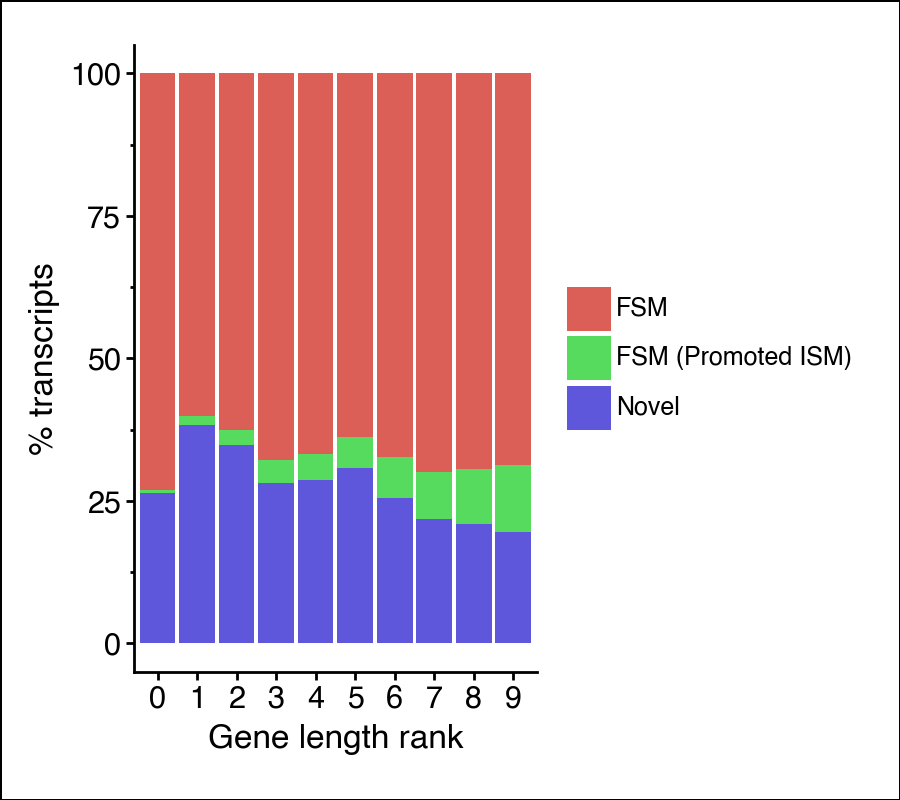

In [111]:
(
    ggplot(temp, aes(x='factor(decile_rank)', y='perc', fill='gene_len_nov'))
    + geom_bar(stat='identity', position='stack')
    # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
    + labs(
        x='Gene length rank',
        y='% transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=4.5, h=4)
)

In [112]:
# also do by novelty + split out promoted ISMs
# add new struct. cat. column 

mt_df['structural_category_2'] = mt_df.structural_category
mt_df.loc[mt_df.gene_len_nov=='FSM (Promoted ISM)', 'structural_category_2'] = 'FSM (Promoted ISM)'

temp = mt_df[['isoform', 'structural_category_2', 'decile_rank']]

temp['n_iso_decile'] = temp[['isoform', 'decile_rank']].groupby('decile_rank').transform('nunique')
temp = temp.groupby(['decile_rank', 'structural_category_2', 'n_iso_decile']).nunique().reset_index().rename({'isoform':'n_iso_decile_cat'}, axis=1)
temp['perc'] = (temp['n_iso_decile_cat']/temp['n_iso_decile'])*100

c_dict, order = get_novelty_colors(mt_df.structural_category.unique().tolist())
c_dict['FSM - Promoted ISM'] = mute_color(c_dict['FSM'], factor=0.5)
order = [order[0]] + ['FSM (Promoted ISM)'] + order[1:]
order

(
    ggplot(temp, aes(x='factor(decile_rank)', y='perc', fill='structural_category_2'))
    + geom_bar(stat='identity', position='stack')
    +scale_fill_manual(c_dict)
    # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
    + labs(
        x='Gene length rank',
        y='% transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=4.5, h=4)
)

temp2 = temp.copy(deep=True)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/808399836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Using the same decile bins, let's look at UMA instead of PODER, and also by all novelty categories

In [113]:
temp_uma_df = pd.read_csv('../supp_tables/02_uma_mt.tsv', sep='\t')
temp_uma_df.rename({'associated_geneid.v':'geneid.v'}, axis=1, inplace=True)

# get gene lengths from the gtf
f = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(f)
gtf_df = gtf_df.df

# just genes
gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
gtf_df['gene_len'] = gtf_df['End']-gtf_df['Start']


# merge gene len into mt
gtf_df['geneid.v'] = gtf_df['gene_id']
temp_uma_df = temp_uma_df.merge(gtf_df[['geneid.v', 'gene_len']], 
                    how='left',
                    on='geneid.v')

# # make sure all nulls are from novel genic things
# assert len(set(mt_df['geneid.v'].tolist())-set(gtf_df['gene_id'].tolist())) == len(mt_df.loc[mt_df['geneid.v'].str.contains('novelGenic')][['geneid.v']].drop_duplicates())

# # remove novel genic things
# mt_df = mt_df.loc[mt_df.gene_len.notnull()]


In [114]:
temp_uma_df.loc[temp_uma_df['gene_len'].isnull()].head()
# temp_uma_df.head()
# len(temp_uma_df.index)
len(temp_uma_df.loc[temp_uma_df['gene_len'].isnull()])

# remove genes that did not make it into PODER in the end
temp_uma_df = temp_uma_df.loc[temp_uma_df.gene_len.notnull()]

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/4195496745.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FSM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/4195496745.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/4195496745.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

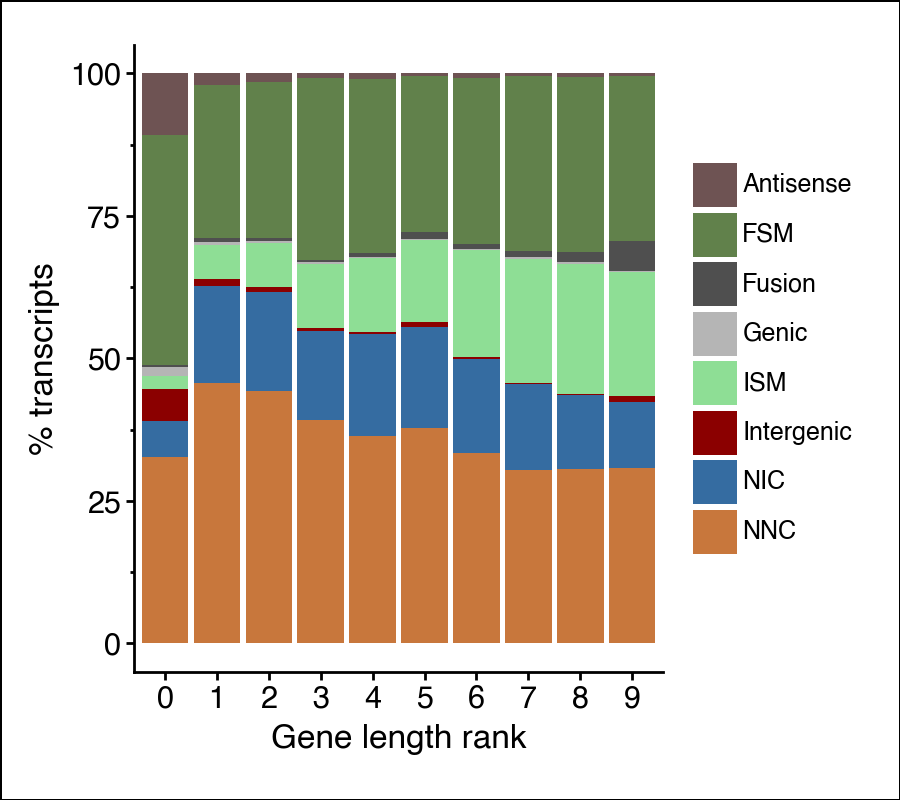

In [115]:

# bin using the same bin edges
temp_uma_df['decile_range'] = pd.cut(temp_uma_df['gene_len'], bins=bin_edges, include_lowest=True)
temp_uma_df['decile_rank'] = pd.cut(temp_uma_df['gene_len'], bins=bin_edges, labels=False, include_lowest=True)


temp_uma_df['gene_len_nov'] = np.nan
temp_uma_df.loc[temp_uma_df.structural_category=='FSM', 'gene_len_nov'] = 'FSM'
temp_uma_df.loc[temp_uma_df.structural_category!='FSM', 'gene_len_nov'] = 'Novel'

temp = temp_uma_df[['isoform', 'structural_category', 'decile_rank']]

temp['decile_rank'] = temp.decile_rank.astype(int)
temp['n_iso_decile'] = temp[['isoform', 'decile_rank']].groupby('decile_rank').transform('nunique')
temp = temp.groupby(['decile_rank', 'structural_category', 'n_iso_decile']).nunique().reset_index().rename({'isoform':'n_iso_decile_cat'}, axis=1)
temp['perc'] = (temp['n_iso_decile_cat']/temp['n_iso_decile'])*100

# also do by novelty + split out promoted ISMs
# add new struct. cat. column 

temp = temp_uma_df[['isoform', 'structural_category', 'decile_rank']]

temp['n_iso_decile'] = temp[['isoform', 'decile_rank']].groupby('decile_rank').transform('nunique')
temp = temp.groupby(['decile_rank', 'structural_category', 'n_iso_decile']).nunique().reset_index().rename({'isoform':'n_iso_decile_cat'}, axis=1)
temp['perc'] = (temp['n_iso_decile_cat']/temp['n_iso_decile'])*100

c_dict, order = get_novelty_colors(temp_uma_df.structural_category.unique().tolist())
order = [order[0]] + ['FSM (Promoted ISM)'] + order[1:]
order

(
    ggplot(temp, aes(x='factor(decile_rank)', y='perc', fill='structural_category'))
    + geom_bar(stat='identity', position='stack')
    +scale_fill_manual(c_dict)
    # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
    + labs(
        x='Gene length rank',
        y='% transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=4.5, h=4)
)

## Let's actually plot these side by side using facets, and order factors correctly

In [116]:
c_dict['FSM (Promoted ISM)'] = '#adc0a4'

In [117]:
temp['annot'] = 'UMA'
temp2['annot'] = 'PODER'
temp2.rename({'structural_category_2':'structural_category'}, axis=1, inplace=True)

In [118]:
temp3 = pd.concat([temp, temp2], axis=0)
temp3.annot.unique()

array(['UMA', 'PODER'], dtype=object)

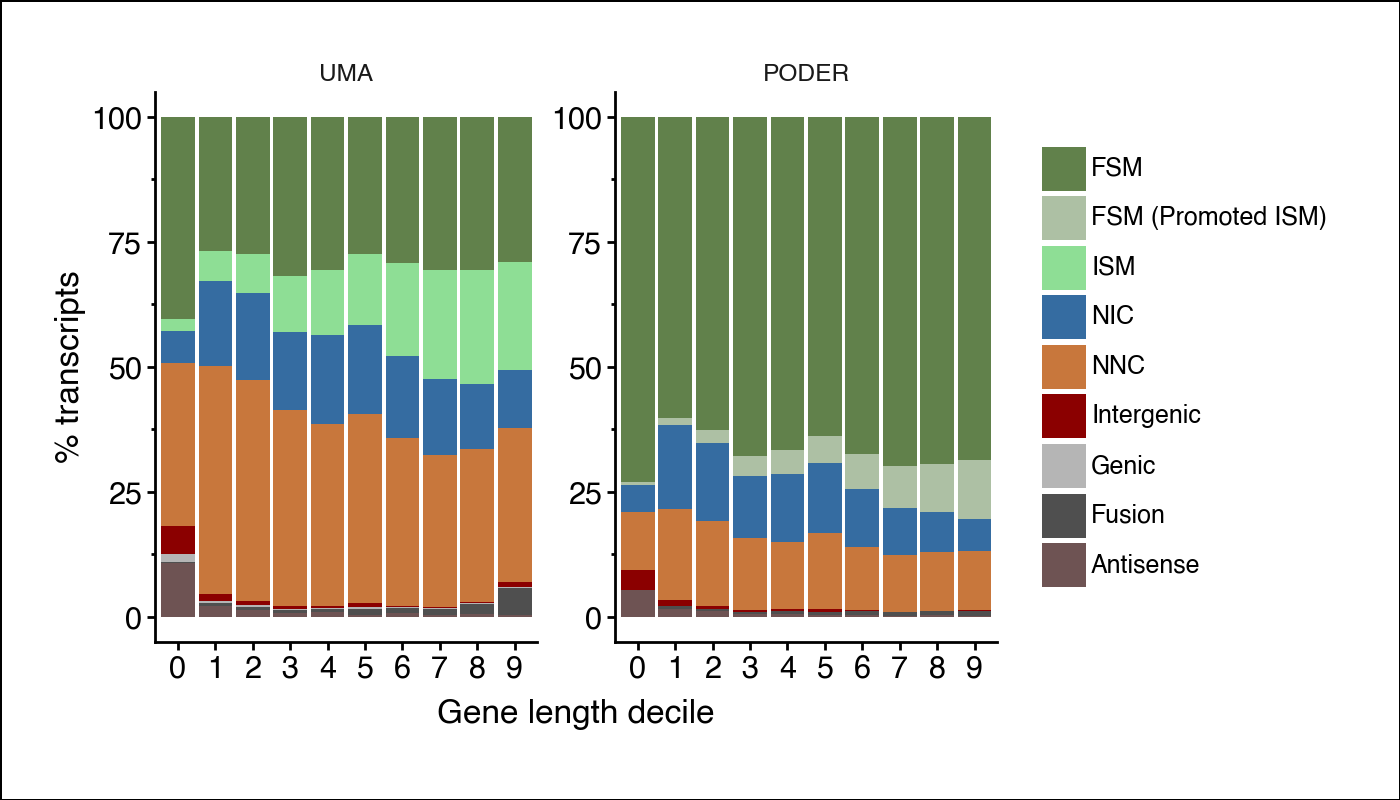

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: perc_transcripts_by_gene_length_decile.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [119]:
# fix ordering of categroies
temp3['structural_category'] = pd.Categorical(temp3['structural_category'], categories=order, ordered=True)
temp3['annot'] = pd.Categorical(temp3['annot'], categories=['UMA', 'PODER'], ordered=True)


p = (
    ggplot(temp3, aes(x='factor(decile_rank)', y='perc', fill='structural_category'))
    + geom_bar(stat='identity', position='stack')
    + scale_fill_manual(c_dict)
    + facet_wrap('~annot',
                 ncol=len(temp3.annot.unique().tolist()),
                 scales='free_y')
    + labs(
        x='Gene length decile',
        y='% transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=7, h=4)
)
p.show()
p.save('perc_transcripts_by_gene_length_decile.pdf', width=7, height=4, dpi=500)


In [121]:
temp3.head()

,decile_rank,structural_category,n_iso_decile,n_iso_decile_cat,perc,annot
0,0,Antisense,8199,885,10.793999,UMA
1,0,FSM,8199,3315,40.431760,UMA
2,0,Fusion,8199,20,0.243932,UMA
3,0,Genic,8199,126,1.536773,UMA
4,0,ISM,8199,196,2.390535,UMA


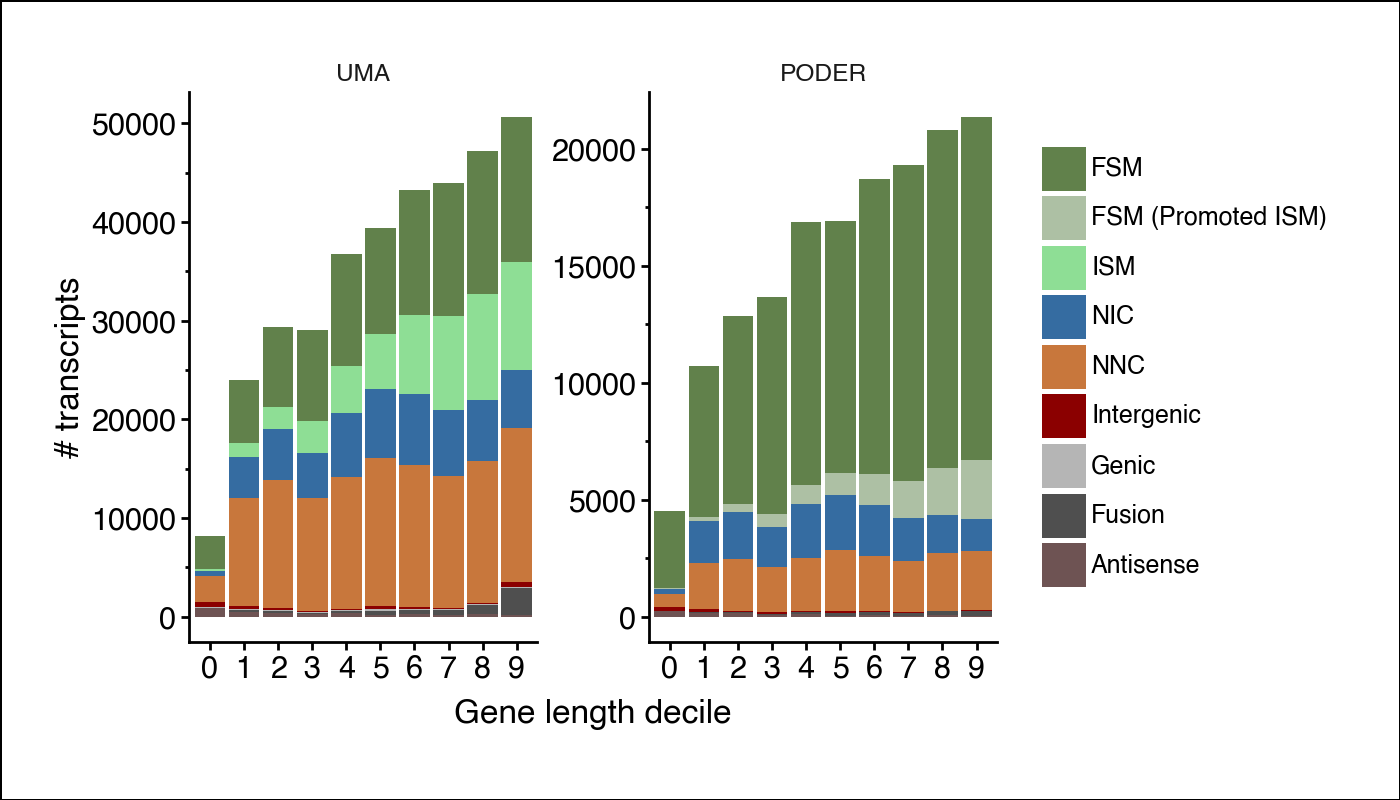

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_transcripts_by_gene_length_decile.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [122]:
# raw number of transcripts instead of proportion
# fix ordering of categroies
temp3['structural_category'] = pd.Categorical(temp3['structural_category'], categories=order, ordered=True)
temp3['annot'] = pd.Categorical(temp3['annot'], categories=['UMA', 'PODER'], ordered=True)


p = (
    ggplot(temp3, aes(x='factor(decile_rank)', y='n_iso_decile_cat', fill='structural_category'))
    + geom_bar(stat='identity', position='stack')
    + scale_fill_manual(c_dict)
    + facet_wrap('~annot',
                 ncol=len(temp3.annot.unique().tolist()),
                 scales='free_y')
    + labs(
        x='Gene length decile',
        y='# transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=7, h=4)
)
p.show()
p.save('n_transcripts_by_gene_length_decile.pdf', width=7, height=4, dpi=500)


In [40]:
# also for the more broad categories
temp3['gene_len_nov'] = np.nan
temp3.loc[temp3.structural_category=='FSM', 'gene_len_nov'] = 'FSM'
temp3.loc[temp3.structural_category!='FSM', 'gene_len_nov'] = 'Novel'
temp3.loc[temp3.structural_category=='FSM (Promoted ISM)', 'gene_len_nov'] ='FSM (Promoted ISM)'

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/2901364168.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FSM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [41]:
temp3 = temp3[['gene_len_nov', 'decile_rank', 'annot', 'perc']].groupby(['gene_len_nov', 'decile_rank', 'annot']).sum().reset_index()
temp3.head()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4089/4029672910.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,gene_len_nov,decile_rank,annot,perc
0,FSM,0,UMA,40.431760
1,FSM,0,PODER,73.049802
2,FSM,1,UMA,26.801249
3,FSM,1,PODER,60.171947
4,FSM,2,UMA,27.444827


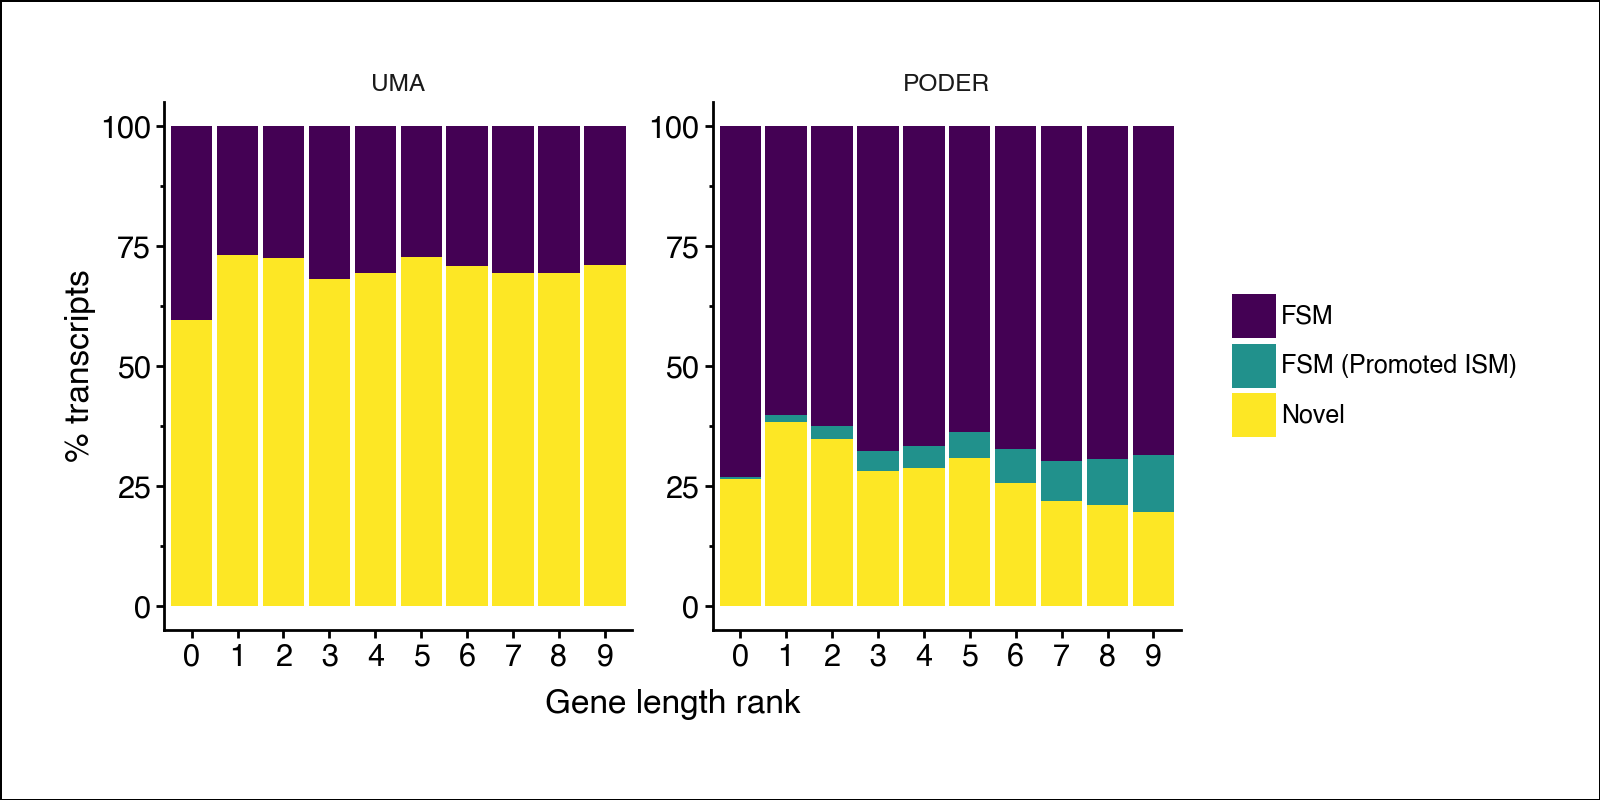

In [42]:
# fix ordering of categories
temp3['gene_len_nov'] = pd.Categorical(temp3['gene_len_nov'], categories=['FSM', 'FSM (Promoted ISM)', 'Novel'] , ordered=True)

(
    ggplot(temp3, aes(x='factor(decile_rank)', y='perc', fill='gene_len_nov'))
    + geom_bar(stat='identity', position='stack')
    # + scale_fill_manual(c_dict)
    + facet_wrap('~annot',
                 ncol=len(temp3.annot.unique().tolist()),
                 scales='free_y')
    + labs(
        x='Gene length rank',
        y='% transcripts',
        fill='Transcript structural category'
    )
    + my_theme(w=8, h=4)
)

## How long are genes that transcripts of different novelty categories come from? 

In [25]:
mt_df[['isoform', 'gene_len', 'gene_len_nov']].head()

,isoform,gene_len,gene_len_nov
0,ENST00000741425.1,116763.0,FSM (Promoted ISM)
1,transcript_0,116763.0,FSM
2,transcript_1,116763.0,FSM
3,transcript_10,116763.0,FSM
4,transcript_11,116763.0,FSM


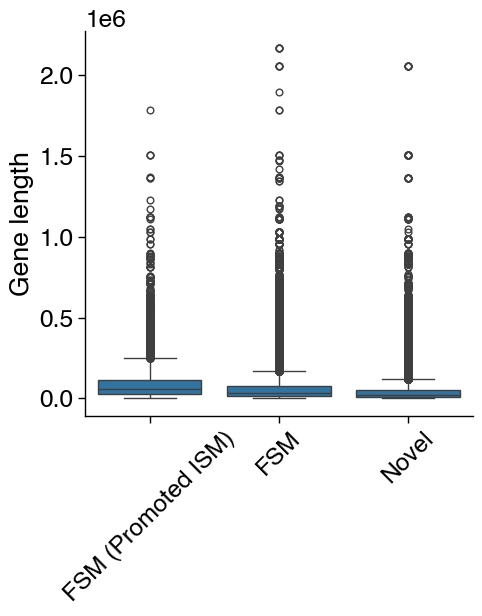

In [26]:
init_plot_settings(aspect='square')
ax = sns.boxplot(mt_df,
                 y='gene_len',
                 x='gene_len_nov')
ax.set(ylabel='Gene length', xlabel='')
clean_figure(ax)

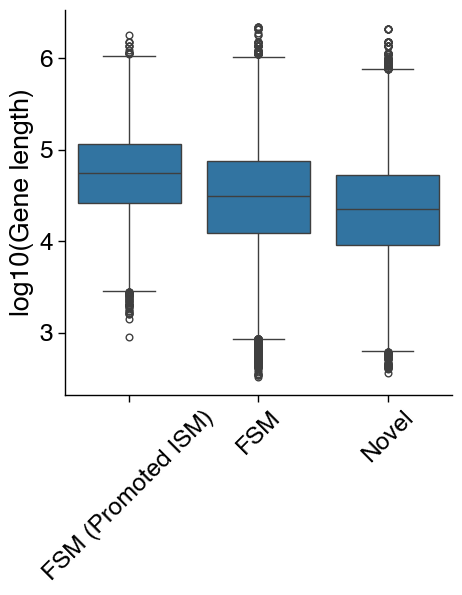

In [27]:
# logged version
init_plot_settings(aspect='square')
mt_df['log10_gene_len'] = np.log10(mt_df['gene_len'])
ax = sns.boxplot(mt_df,
                 y='log10_gene_len',
                 x='gene_len_nov')
ax.set(ylabel='log10(Gene length)', xlabel='')
clean_figure(ax)

In [28]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(mt_df.gene_len_nov.unique().tolist(), 2)):
    x = mt_df.loc[mt_df.gene_len_nov==s[0], 'gene_len'].tolist()
    y = mt_df.loc[mt_df.gene_len_nov==s[1], 'gene_len'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM (Promoted ISM) median: 55483.0
FSM median: 31244.0
678169449.5
0.0

FSM (Promoted ISM) median: 55483.0
Novel median: 22462.0
294614729.0
0.0

FSM median: 31244.0
Novel median: 22462.0
2423288164.5
0.0



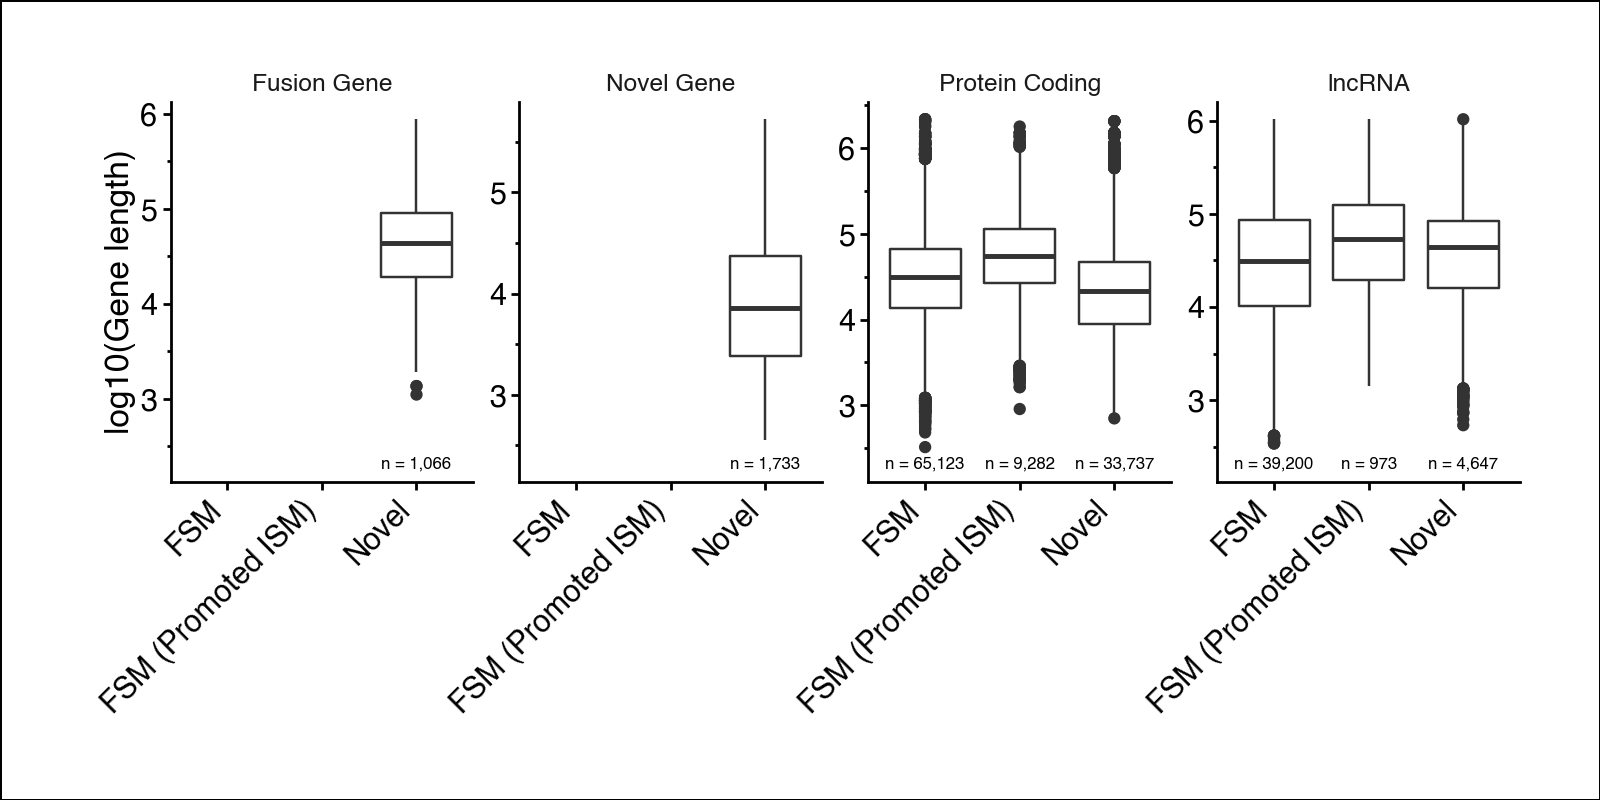

In [29]:
# plotnine version faceted by gene biotype

# 1. Count n per gene_len_nov per facet
n_labels = (
    mt_df.groupby(['associated_gene_biotype_sub', 'gene_len_nov'])
    .size()
    .reset_index(name='n')
)

# 2. Format label
n_labels['label'] = 'n = ' + n_labels['n'].apply(lambda x: f"{x:,}")

# 2. Set fixed y-position below boxes
y_min = mt_df['log10_gene_len'].min()
n_labels['y'] = y_min - 0.2  # tweak -0.2 as needed to move lower


(
    ggplot(mt_df, aes(x='gene_len_nov', y='log10_gene_len'))
    + geom_boxplot()
    + facet_wrap('~associated_gene_biotype_sub',
                 ncol=len(mt_df.associated_gene_biotype_sub.unique().tolist()),
                 scales='free_y')  # Adjust ncol as needed
    + labs(
        y='log10(Gene length)',
        x=''
    )
    + geom_text(
        n_labels,
        aes(x='gene_len_nov', y='y', label='label'),
        inherit_aes=False,
        size=6  # increase for readability if needed
    )
    + my_theme(w=8, h=4)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1))
)

In [30]:
# well, they look different but also let's check 
import itertools
for c in mt_df.associated_gene_biotype_sub.unique().tolist():
    temp = mt_df.loc[mt_df.associated_gene_biotype_sub==c]
    for s in list(itertools.combinations(mt_df.gene_len_nov.unique().tolist(), 2)):
        x = temp.loc[temp.gene_len_nov==s[0], 'gene_len'].tolist()
        y = temp.loc[temp.gene_len_nov==s[1], 'gene_len'].tolist()
        stat, pval = st.mannwhitneyu(x, y)
        # print(f'{s[0]} vs {s[1]}')
        print(c)
        print(f'{s[0]} median: {np.median(x)}')
        print(f'{s[1]} median: {np.median(y)}')
        print(stat)
        print(pval)
        print()

lncRNA
FSM (Promoted ISM) median: 53794.0
FSM median: 31367.0
23511833.0
1.8406238998361238e-35

lncRNA
FSM (Promoted ISM) median: 53794.0
Novel median: 44282.0
2598131.5
2.279714362038868e-13

lncRNA
FSM median: 31367.0
Novel median: 44282.0
82472245.0
4.969447985475255e-26

Protein Coding
FSM (Promoted ISM) median: 55516.5
FSM median: 31151.0
386995222.5
0.0

Protein Coding
FSM (Promoted ISM) median: 55516.5
Novel median: 21462.0
223225790.5
0.0

Protein Coding
FSM median: 31151.0
Novel median: 21462.0
1279288220.0
0.0

Fusion Gene
FSM (Promoted ISM) median: nan
FSM median: nan
nan
nan

Fusion Gene
FSM (Promoted ISM) median: nan
Novel median: 43809.0
nan
nan

Fusion Gene
FSM median: nan
Novel median: 43809.0
nan
nan

Novel Gene
FSM (Promoted ISM) median: nan
FSM median: nan
nan
nan

Novel Gene
FSM (Promoted ISM) median: nan
Novel median: 7259.0
nan
nan

Novel Gene
FSM median: nan
Novel median: 7259.0
nan
nan



/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_52359/3983452282.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide


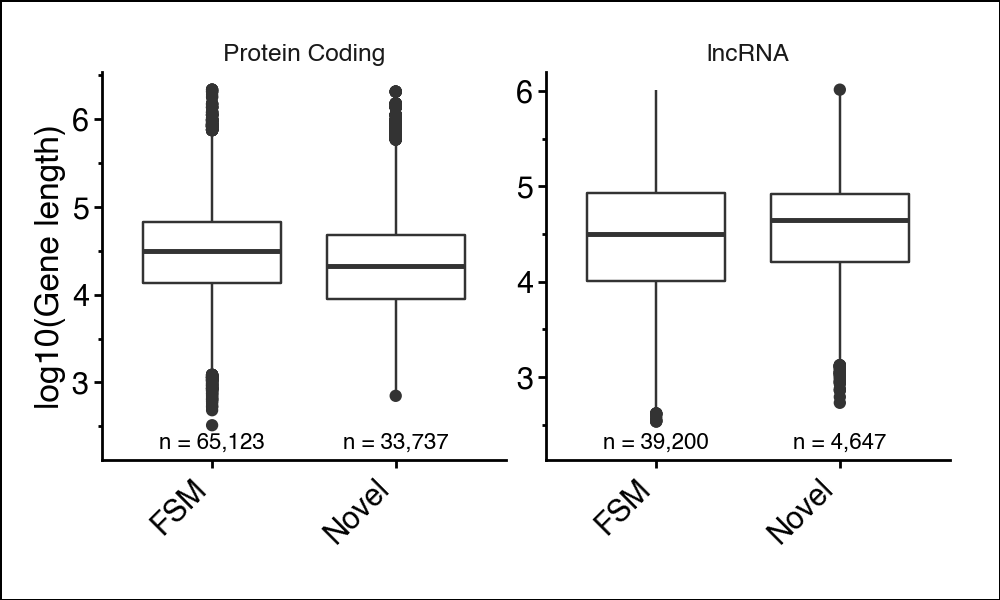

In [31]:
# limit just to pc and lnc, and just to novel vs. fsm
temp = mt_df.loc[(mt_df.associated_gene_biotype_sub.isin(['Protein Coding', 'lncRNA']))&\
                 (mt_df.gene_len_nov.isin(['Novel', 'FSM']))]

# plotnine version faceted by gene biotype

# 1. Count n per gene_len_nov per facet
n_labels = (
    temp.groupby(['associated_gene_biotype_sub', 'gene_len_nov'])
    .size()
    .reset_index(name='n')
)

# 2. Format label
n_labels['label'] = 'n = ' + n_labels['n'].apply(lambda x: f"{x:,}")

# 2. Set fixed y-position below boxes
y_min = temp['log10_gene_len'].min()
n_labels['y'] = y_min - 0.2  # tweak -0.2 as needed to move lower


(
    ggplot(temp, aes(x='gene_len_nov', y='log10_gene_len'))
    + geom_boxplot()
    + facet_wrap('~associated_gene_biotype_sub',
                 ncol=len(temp.associated_gene_biotype_sub.unique().tolist()),
                 scales='free_y')  # Adjust ncol as needed
    + labs(
        y='log10(Gene length)',
        x=''
    )
    + geom_text(
        n_labels,
        aes(x='gene_len_nov', y='y', label='label'),
        inherit_aes=False,
        size=8  # increase for readability if needed
    )
    + my_theme(w=5, h=3)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1))
)

In [32]:
# well, they look different but also let's check 
import itertools
for c in temp.associated_gene_biotype_sub.unique().tolist():
    temp2 = temp.loc[temp.associated_gene_biotype_sub==c]
    for s in list(itertools.combinations(temp.gene_len_nov.unique().tolist(), 2)):
        x = temp2.loc[temp.gene_len_nov==s[0], 'gene_len'].tolist()
        y = temp2.loc[temp.gene_len_nov==s[1], 'gene_len'].tolist()
        stat, pval = st.mannwhitneyu(x, y)
        # print(f'{s[0]} vs {s[1]}')
        print(c)
        print(f'{s[0]} median: {np.median(x)}')
        print(f'{s[1]} median: {np.median(y)}')
        print(stat)
        print(pval)
        print()

lncRNA
FSM median: 31367.0
Novel median: 44282.0
82472245.0
4.969447985475255e-26

Protein Coding
FSM median: 31151.0
Novel median: 21462.0
1279288220.0
0.0



## Correlate gene length with the number of transcripts

In [33]:
gb_cols = ['geneid.v', 'associated_gene_biotype_sub',
        'gene_len', 'log10_gene_len']
keep_cols = gb_cols + ['isoform']
temp = mt_df[keep_cols].groupby(gb_cols).nunique().rename({'isoform':'n_t'}, axis=1).reset_index()
temp.head()

,geneid.v,associated_gene_biotype_sub,gene_len,log10_gene_len,n_t
0,ENSG00000000003.16,Protein Coding,9699.0,3.986727,1
1,ENSG00000000005.6,Protein Coding,14950.0,4.174641,1
2,ENSG00000000419.14,Protein Coding,24473.0,4.388687,24
3,ENSG00000000457.14,Protein Coding,44637.0,4.649695,6
4,ENSG00000000460.17,Protein Coding,59351.0,4.773428,5


In [34]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [35]:
def plot_thing(df, c1, c2, hue):
        c_dict = {'Protein Coding': 'k', 
              'Fusion Gene': 'b',
              'lncRNA': 'r', 
              'Novel Gene': 'g'}
        ax = sns.jointplot(data=df, x=c1, y=c2,
                             hue=hue, palette=c_dict,
                             # xlim=(0,xlim), ylim=(0,ylim), 
                             joint_kws={'data':df, 's':40, 'alpha':0.4})
        ax = ax.ax_joint
        
        # plot regression lines and equation of regression lines
        # https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot/68135585#68135585
        # https://stackoverflow.com/questions/45902739/seaborn-annotate-the-linear-regression-equation
        # https://stackoverflow.com/questions/62705904/add-entry-to-matplotlib-legend-without-plotting-an-object
        lines = []
        labels = []
        for s in df[hue].unique().tolist():
            temp = df.loc[df[hue] == s]
            color = c_dict[s]
            line_color = adjust_lightness(color, 0.5)
            
            # get coeffs of linear fit
            slope, intercept, r_value, p_value, std_err = stats.linregress(temp[c1],temp[c2])
            lines += [mpl.lines.Line2D([0], [0], color=line_color)]
            labels += ['m={0:.1f}'.format(slope)]
    
            print('Slope of {} correlation: {}'.format(s, slope))
            print(f'Pval = {p_value}')
            print(f'n = {len(temp.index)}')
            
            
            sns.regplot(data=temp, x=c1, y=c2,
                        scatter=False, ax=ax, color=color)
            sns.regplot(data=temp, x=c1, y=c2,
                scatter=False, ax=ax, color=color, ci=0,
                line_kws={'color':line_color,
                          'linestyle':'-',
                          'label':"m={0:.1f}".format(slope)})
        
        ax.legend(title='')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_legend().remove()

        _ = ax.set(xlabel='log10(Gene length)', ylabel='# transcripts / gene')

Slope of Protein Coding correlation: 0.5132669637874888
Pval = 9.585668019716695e-05
n = 13880
Slope of Fusion Gene correlation: -0.15430127009909952
Pval = 0.280643568019393
n = 584
Slope of lncRNA correlation: 5.371127968528526
Pval = 2.4971913885866147e-154
n = 8737
Slope of Novel Gene correlation: 0.718851284362762
Pval = 5.759783956002065e-26
n = 1124


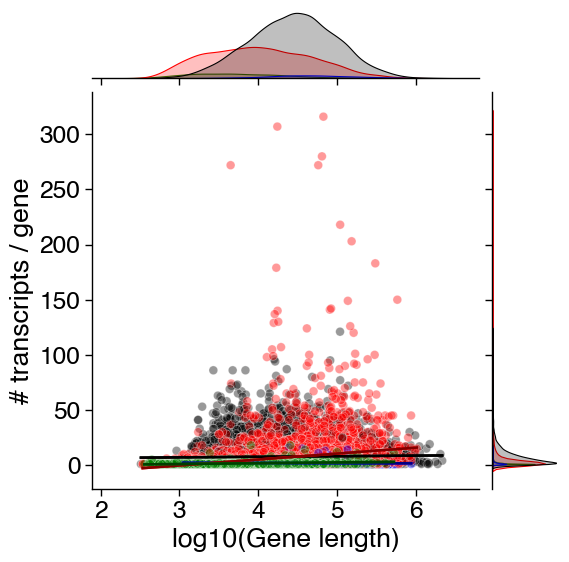

In [36]:
plot_thing(temp, 'log10_gene_len', 'n_t', 'associated_gene_biotype_sub')

Slope of Protein Coding correlation: 0.5132669637874888
Pval = 9.585668019716695e-05
n = 13880
Slope of lncRNA correlation: 5.371127968528526
Pval = 2.4971913885866147e-154
n = 8737


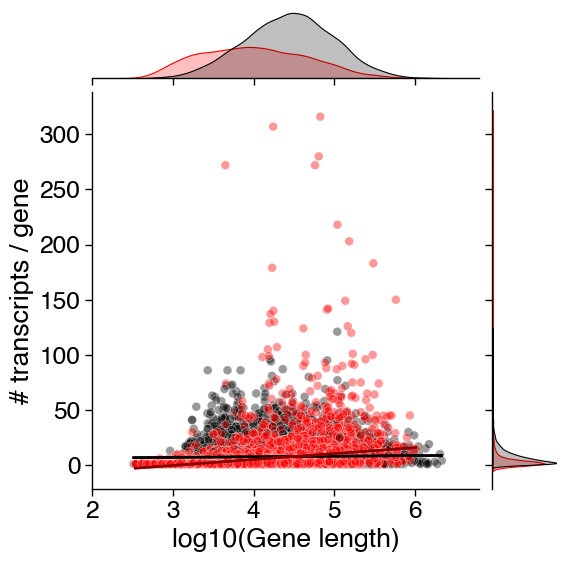

In [37]:
# try limiting just to pc /  lnc cause this is interesting
temp2 = temp.loc[temp.associated_gene_biotype_sub.isin(['Protein Coding', 'lncRNA'])]
plot_thing(temp2, 'log10_gene_len', 'n_t', 'associated_gene_biotype_sub')


In [38]:
temp2.head()

,geneid.v,associated_gene_biotype_sub,gene_len,log10_gene_len,n_t
0,ENSG00000000003.16,Protein Coding,9699.0,3.986727,1
1,ENSG00000000005.6,Protein Coding,14950.0,4.174641,1
2,ENSG00000000419.14,Protein Coding,24473.0,4.388687,24
3,ENSG00000000457.14,Protein Coding,44637.0,4.649695,6
4,ENSG00000000460.17,Protein Coding,59351.0,4.773428,5


In [46]:
# maybe pearson or spearman correlation would be better actually
# maybe summarize these correlations in a bar plot because it's neater
hue = 'associated_gene_biotype_sub'
c1 = 'log10_gene_len'
c2 = 'n_t'
pearsons = []
pearson_ps = []
spearmans = []
spearman_ps = []
for s in temp2[hue].unique().tolist():
    temp = temp2.loc[temp2[hue] == s]
    
    # get correlations
    x = temp[c1].tolist()
    y = temp[c2].tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    pearsons.append(r)
    pearson_ps.append(r_p)
    spearmans.append(rho)
    spearman_ps.append(r_p)
    

In [49]:
temp = pd.DataFrame({'pearson': pearsons,
                     'pearson_pval': pearson_ps,
                     'spearman': spearmans,
                     'spearman_pval': spearman_ps,
                     hue: temp2[hue].unique().tolist()})

In [50]:
temp

,pearson,pearson_pval,spearman,spearman_pval,associated_gene_biotype_sub
0,0.033104,9.585668e-05,0.134792,9.585668e-05,Protein Coding
1,0.277584,2.497191e-154,0.476790,2.497191e-154,lncRNA


In [ ]:
## Do longer genes have fewer novel transcripts? (did i already answer this q?)